<a href="https://colab.research.google.com/github/bishair/Model-Improvements/blob/main/G10-improvements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import joblib
from IPython.display import display, clear_output

In [3]:
uploaded_file = files.upload()

Saving riverL.xlsx to riverL.xlsx


In [15]:
# Read the groundwater level data
gw_data = pd.read_excel('groundwater.xlsx')
gw_data.dropna(inplace=True)
gw_data['Date'] = pd.to_datetime(gw_data['Date'], format='%d/%m/%Y %H:%M')
#print(gw_data)

# Read the river water level data
river_data = pd.read_excel('riverL.xlsx')
river_data['Date'] = pd.to_datetime(river_data['Date'], format='%d/%m/%Y %H:%M')
#print(river_data)

# Merge the two datasets on the 'Date' column
merged_data = pd.merge_asof(gw_data.sort_values('Date'), river_data.sort_values('Date'), on='Date', direction='nearest')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)
print(merged_data)

                         G10  River
Date                               
2015-01-30 12:18:00  110.722    261
2015-01-30 13:18:00  110.720    260
2015-01-30 14:18:00  110.718    260
2015-01-30 15:18:00  110.715    260
2015-01-30 16:18:00  110.714    260
...                      ...    ...
2017-01-30 10:19:00  109.456    136
2017-01-30 11:19:00  109.455    138
2017-01-30 12:19:00  109.456    141
2017-01-30 13:19:00  109.457    144
2017-01-30 14:19:00  109.459    146

[17329 rows x 2 columns]


In [21]:
n_steps = 24

# Create a copy of the DataFrame to have date as column
merged_data_copy = merged_data.copy()
merged_data_copy.reset_index(inplace=True)
dates = merged_data_copy['Date']


# Split the merged data 70% training 30% testing
train_size = int(len(merged_data) * 0.7)
merged_data_train = merged_data[:train_size]
merged_data_test = merged_data[train_size:]


# Split dates along with the data
dates_train = dates[:train_size]
dates_test = dates[train_size:]

# Apply MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(merged_data_train)
test_scaled = scaler.transform(merged_data_test)

#Save the scaler
joblib.dump(scaler, 'scaler.gz')

def create_sequences_with_dates(data, dates, n_steps):
    X, y, dates_seq = [], [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, :])
        y.append(data[i, 0])
        dates_seq.append(dates.iloc[i - n_steps + 1 : i + 1])  # Capture the full range of dates for each sequence
    return np.array(X), np.array(y), np.array(dates_seq)

# create sequences
X_train, y_train, dates_train_seq = create_sequences_with_dates(train_scaled, dates_train, n_steps)
X_test, y_test, dates_test_seq = create_sequences_with_dates(test_scaled, dates_test, n_steps)

#Numpy arrays
#print('X_train shape:', X_train.shape)
#print('y_train shape:', y_train.shape)
#print('X_test shape:', X_test.shape)
#print('y_test shape:', y_test.shape)
#print('Dates for training data',dates_train_seq)
#print('Dates for testing data',dates_test_seq.shape)

In [32]:
from sklearn.model_selection import train_test_split

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Epoch 1/25
605/606 [============================>.] - ETA: 0s - loss: 0.0523
Epoch 1: val_loss improved from inf to 0.00327, saving model to best_model.h5
606/606 [==============================] - 57s 83ms/step - loss: 0.0523 - val_loss: 0.0033
Epoch 2/25
605/606 [============================>.] - ETA: 0s - loss: 0.0058
Epoch 2: val_loss did not improve from 0.00327
606/606 [==============================] - 37s 62ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 3/25
605/606 [============================>.] - ETA: 0s - loss: 0.0052
Epoch 3: val_loss improved from 0.00327 to 0.00262, saving model to best_model.h5
606/606 [==============================] - 37s 61ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 4/25
605/606 [============================>.] - ETA: 0s - loss: 0.0048
Epoch 4: val_loss did not improve from 0.00262
606/606 [==============================] - 36s 59ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 5/25
605/606 [============================>.] - ETA: 0s - loss: 0.00

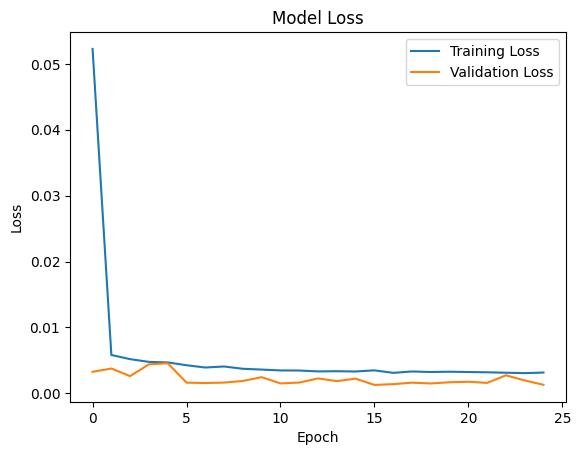

In [33]:
input_shape=(X_train.shape[1], X_train.shape[2])

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.regularizers import l1_l2

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=input_shape,   #input shape => (timesteps, features).  X => (samples, timesteps, features)
         dropout=0.2, recurrent_dropout=0.2,
         kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dropout(0.2),
    LSTM(units=50, dropout=0.2, recurrent_dropout=0.2),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Fit the model with validation data and callbacks
history = model.fit(
    X_train, y_train, epochs=25, batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, model_checkpoint]
)

# Plotting the training and validation loss
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [34]:
model.save('lstmmodel.h5')
model = load_model('lstmmodel.h5')
scaler = joblib.load('scaler.gz')

-------------------TOMORROW---------------------

In [30]:
# Only use 360 hours (15days) from X and y to test the real time part. Use evaluate on X-test-evaluate and real time workflow on X-realtime

In [27]:
# Function to retrain the model with new data
def retrain_model(model, X_new, y_new, epochs=5, batch_size=32):
    # Partial retraining of the model with new data
    model.fit(X_new, y_new, epochs=epochs, batch_size=batch_size, shuffle=True)
    return model

In [ ]:
#Function to introduce anomalies in copy of X-test data. Compare model performance then on copy Xtest with anomalies and Xtest without anomalies
#X-tets is scales? Anomalies scaling?
def introduce_anomalies(X_test, anomaly_type="spike", magnitude=5.0, frequency=0.01):
    """
    Introduce anomalies into the test dataset.

    Parameters:
    X_test (numpy array): The test dataset.
    anomaly_type (str): Type of anomaly - 'spike', 'shift', 'noise', or 'gap'.
    magnitude (float): Magnitude of the anomaly.
    frequency (float): Frequency of anomalies (as a fraction of the total length of X_test).
    """
    # Copy the dataset to avoid modifying the original
    X_anomalous = np.copy(X_test)

    num_samples = X_anomalous.shape[0]
    num_anomalies = int(num_samples * frequency)

    # Indices where anomalies will be introduced
    anomaly_indices = np.random.choice(num_samples, num_anomalies, replace=False)

    if anomaly_type == "spike":
        # Introduce spikes
        for idx in anomaly_indices:
            X_anomalous[idx] *= magnitude

    elif anomaly_type == "shift":
        # Introduce shifts in mean
        shift_value = np.random.rand() * magnitude
        for idx in anomaly_indices:
            X_anomalous[idx] += shift_value

    elif anomaly_type == "noise":
        # Introduce random noise
        noise = np.random.normal(0, magnitude, X_anomalous.shape[1])
        for idx in anomaly_indices:
            X_anomalous[idx] += noise

    return X_anomalous

# Example usage
X_test_anomalous = introduce_anomalies(X_test, anomaly_type="spike", magnitude=10, frequency=0.05)